In [59]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
# from data_loading import read_hackathon_data
from dataset.june_dataset import JuNEDataset

from metrics.metrics_time import TimeMetrics
from itertools import product
import matplotlib.pyplot as plt
import pingouin as pg

df = pd.read_csv('../data/all_data_final_with_ds_labels.csv', index_col=0).reset_index()
june = JuNEDataset(df)
june.prepare_dataset()
df = june.df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
df.head()

,index,time,session_id,kernel_id,notebook_name,event,cell_index,cell_num,cell_type,cell_source,cell_output,user_id,labels,task,expert
0,0,2023-05-06 10:32:26.282,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,save_notebook,None,None,None,"[\n {\n ""id"": ""35c0b3b694f84140846a21197ea...",None,student_7,None,task1,False
1,1,2023-05-06 10:32:55.892,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,"helper_functions,",task1,False
2,2,2023-05-06 10:32:56.229,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,"helper_functions,",task1,False
3,3,2023-05-06 10:32:58.048,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,None,student_7,"helper_functions,",task1,False
4,4,2023-05-06 10:32:58.429,709ce80b-90a5-457e-bf6f-b7033a3261b5,bc147b33-fa74-4bff-9f48-c88809c5bdcd,task1.ipynb,finished_execute,35c0b3b694f84140846a21197ea62f68,0.0,code,from mining_extension import check_logging \nc...,"[{""output_type"":""stream"",""size"":23}]",student_7,"helper_functions,",task1,False


In [61]:
TM = TimeMetrics()
metrics = TM.calculate_metrics(df)
metrics.head()
kernel_mapping  = metrics.loc[:, ['kernel_id', 'task', 'expert']].drop_duplicates()

# Action time

In [62]:
metrics.groupby(['task', 'expert']).next_action_time.describe()

count       mean         std  min    25%     50%       75%  \
task  expert                                                                 
task1 False   10127.0  24.297837  232.225635  0.0  0.122  1.3030  10.76800   
      True     2742.0  17.895396   56.868813  0.0  0.050  0.9380  12.48675   
task2 False    3066.0  24.054998  242.039339  0.0  0.113  1.0340   8.11775   
      True     4882.0  16.264002  117.188818  0.0  0.056  0.6465   6.08375   

                    max  
task  expert             
task1 False   12433.658  
      True     1423.788  
task2 False    9607.723  
      True     4114.957

In [63]:
tr = metrics.next_action_time.quantile(.95)
at_df = metrics.loc[((metrics.next_action_time < tr) & (metrics.event != 'execute')), :]

In [64]:
at_df.groupby(['task', 'expert']).next_action_time.describe()

count       mean        std  min      25%    50%       75%  \
task  expert                                                                
task1 False   5018.0  12.354163  16.120181  0.0  1.06325  5.741  16.94175   
      True    1375.0  14.946523  17.828364  0.0  1.90650  7.644  21.60900   
task2 False   1573.0  10.475886  14.824908  0.0  1.26200  4.420  13.08200   
      True    2681.0   8.826441  13.484464  0.0  0.53700  3.082  10.19800   

                 max  
task  expert          
task1 False   74.308  
      True    74.109  
task2 False   74.233  
      True    74.281

In [90]:

sns.set(rc={'figure.figsize':(13.7,6.27)})
def plot_box_time(df, var='next_action_time'):

    df = df[df.labels.apply(lambda x: len(x.strip().split(',')) - 1 if isinstance(x, str) else None) == 1]
    my_order = df.groupby(by=["labels"])[var].mean()
    my_order = my_order.sort_values().index

    sns.boxplot(df, x='labels', y =var, order=my_order)

    plt.xticks(rotation=90)


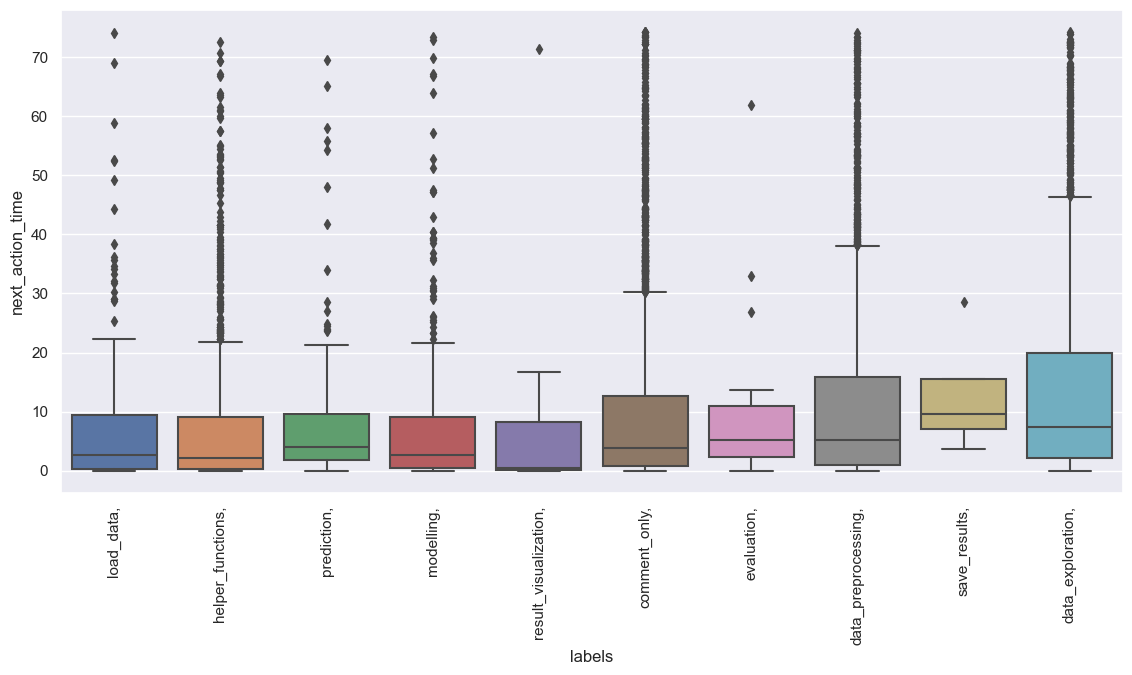

In [84]:
plot_box_time(at_df)

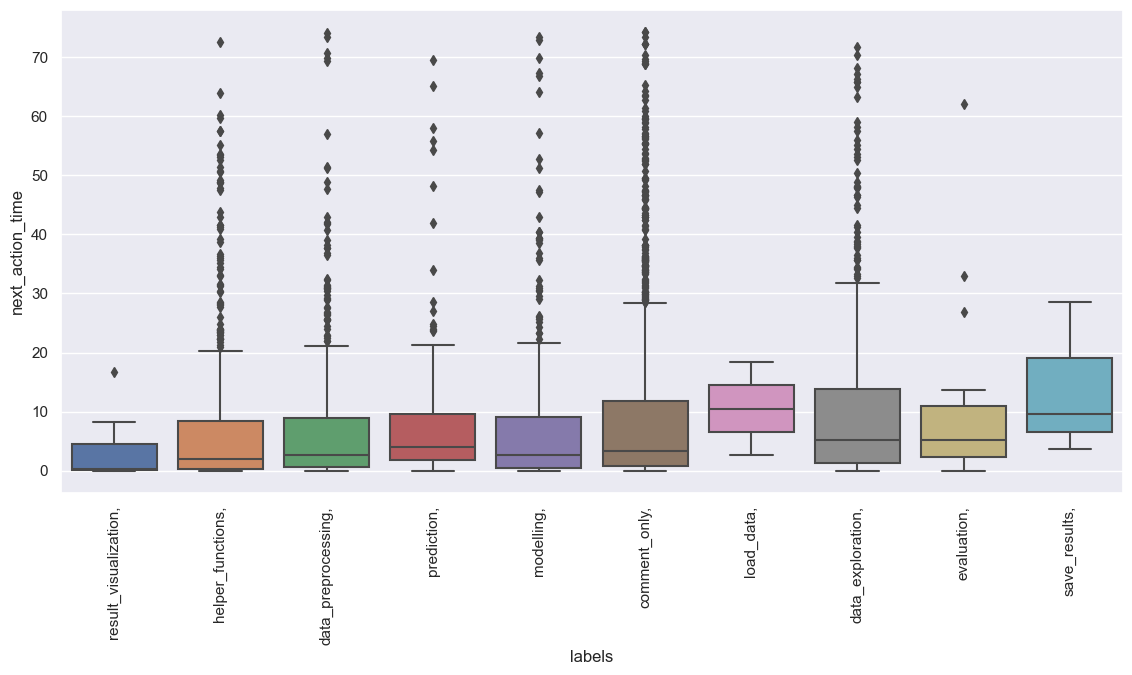

In [85]:
plot_box_time(at_df[at_df.task == 'task2'])

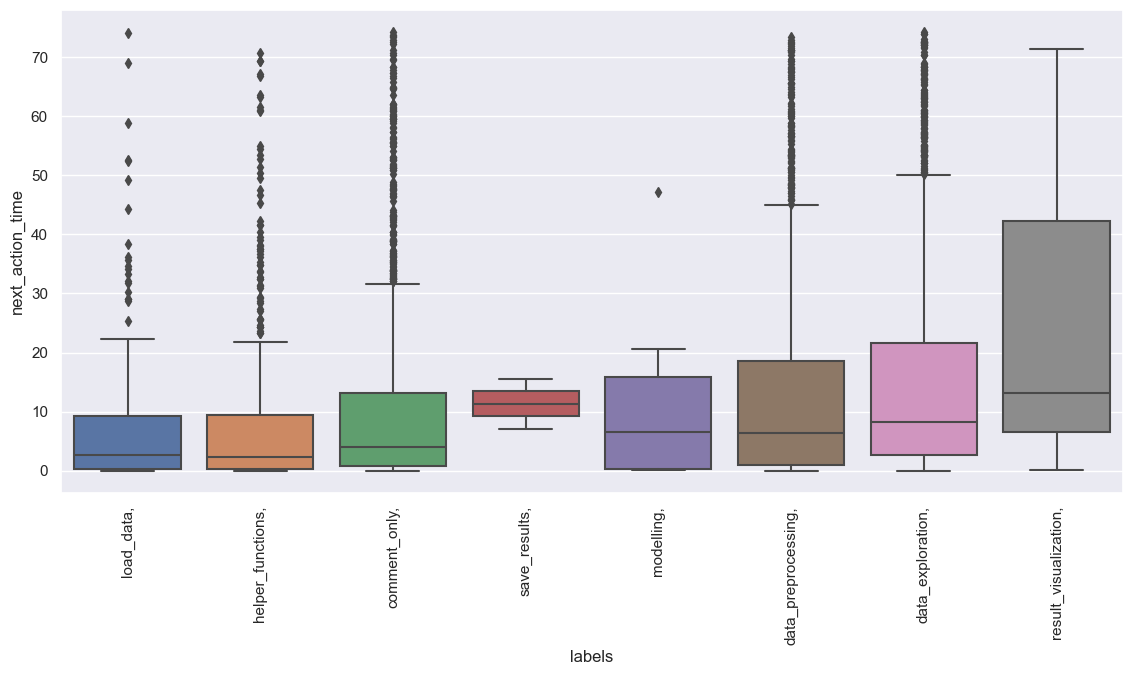

In [86]:
plot_box_time(at_df[at_df.task == 'task1'])

# Execution time

In [69]:
# TODO:
# deal with missing execs
# metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'state_time_dt']].state_time_dt.isna().sum()

In [70]:
metrics.columns

Index(['index', 'time', 'session_id', 'kernel_id', 'notebook_name', 'event',
       'cell_index', 'cell_num', 'cell_type', 'cell_source', 'cell_output',
       'user_id', 'labels', 'task', 'expert', 'execution_time',
       'execution_start', 'result', 'interruptions', 'src_len',
       'execution_time_sec', 'next_action_time'],
      dtype='object')

In [71]:
metrics.loc[metrics.event == 'execute', 'cell_index'].nunique(), len(metrics[metrics.event == 'execute'])

(1963, 9207)

In [72]:
sum_exec = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].sum()).to_frame('exec_time_sum') / 60
sum_exec_count = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].count()).to_frame('exec_time_count')
sum_exec_mean = metrics.groupby('kernel_id').apply(lambda x: x.loc[x.event == 'execute', 'execution_time_sec'].mean()).to_frame('exec_time_mean') / 60
sum_all = metrics.groupby('kernel_id').next_action_time.sum().to_frame('overall_time') / 60

kernel_time_df = kernel_mapping.merge(sum_exec, on = 'kernel_id').merge(sum_exec_mean, on = 'kernel_id').merge(sum_all, on = 'kernel_id').merge(sum_exec_count, on = 'kernel_id')
kernel_time_df['percent'] = kernel_time_df.exec_time_sum / kernel_time_df.overall_time * 100
kernel_time_df['exec_time_n'] = kernel_time_df.exec_time_sum / kernel_time_df.exec_time_count
exec_comp = kernel_time_df.groupby(['task', 'expert']).describe()

cols = list(product(['exec_time_sum', 'percent','exec_time_n'],['mean', 'std']))
exec_stats = exec_comp.loc[:,cols]
exec_stats

# print(exec_stats.round(2).applymap('{:.2f}'.format).to_latex(escape = True, multirow=True))

exec_time_sum               percent            exec_time_n  \
                      mean        std       mean        std        mean   
task  expert                                                              
task1 False      15.491702  13.892578   7.595566   8.481667    0.046091   
      True        4.852870   4.124956   2.938843   2.575714    0.021221   
task2 False      28.608836  27.395937  11.872099   9.523796    0.124502   
      True       30.828633  38.964322  14.202521  13.354786    0.089659   

                        
                   std  
task  expert            
task1 False   0.024745  
      True    0.020112  
task2 False   0.077949  
      True    0.100282

In [73]:
execs = metrics.loc[metrics.event == 'execute', ['kernel_id','expert','task', 'execution_time_sec']].dropna()

In [77]:
execs.anova(dv="execution_time_sec", between=["expert", "task"]).round(3)

,Source,SS,DF,MS,F,p-unc,np2
0,expert,6539.547,1.0,6539.547,6.476,0.011,0.001
1,task,36139.237,1.0,36139.237,35.787,0.000,0.004
2,expert * task,80.944,1.0,80.944,0.080,0.777,0.000
3,Residual,9063344.666,8975.0,1009.843,NaN,NaN,NaN


In [78]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_count']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,1.46,16.83,two-sided,0.16,"[-33.81, 185.78]",0.51,0.868,0.15


In [79]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task1')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.23,8.71,two-sided,0.05,"[-0.0, 0.05]",1.05,1.996,0.48


In [80]:
t1_execs_s = kernel_time_df.loc[((~kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
t1_execs_e = kernel_time_df.loc[((kernel_time_df.expert) & (kernel_time_df.task == 'task2')), 'exec_time_n']
pg.ttest(t1_execs_s, t1_execs_e).round(2)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.67,10,two-sided,0.52,"[-0.08, 0.15]",0.39,0.54,0.09


In [96]:
metrics.groupby('labels').execution_time_sec.describe().sort_values(by='mean')

,count,mean,std,min,25%,50%,75%,max
labels,,,,,,,,
"evaluation,",16.0,0.075000,0.080208,0.001,0.02300,0.0435,0.12900,0.299
"helper_functions,evaluation,",37.0,0.125865,0.062612,0.002,0.10400,0.1520,0.16100,0.245
"result_visualization,",12.0,0.142000,0.139930,0.003,0.06625,0.0815,0.15650,0.467
"helper_functions,data_exploration,",9.0,0.432889,0.206776,0.045,0.33800,0.4720,0.49300,0.827
"prediction,",194.0,0.540155,2.737858,0.004,0.05700,0.1240,0.18875,26.227
"load_data,data_exploration,",15.0,0.599867,0.256084,0.001,0.53450,0.7390,0.76200,0.774
"load_data,",220.0,0.643182,1.870342,0.000,0.04175,0.1620,0.63525,18.155
"comment_only,",1051.0,0.706887,6.704457,0.000,0.03200,0.0470,0.10450,139.579
"data_exploration,modelling,",4.0,0.907250,0.603882,0.555,0.55950,0.6335,0.98125,1.807


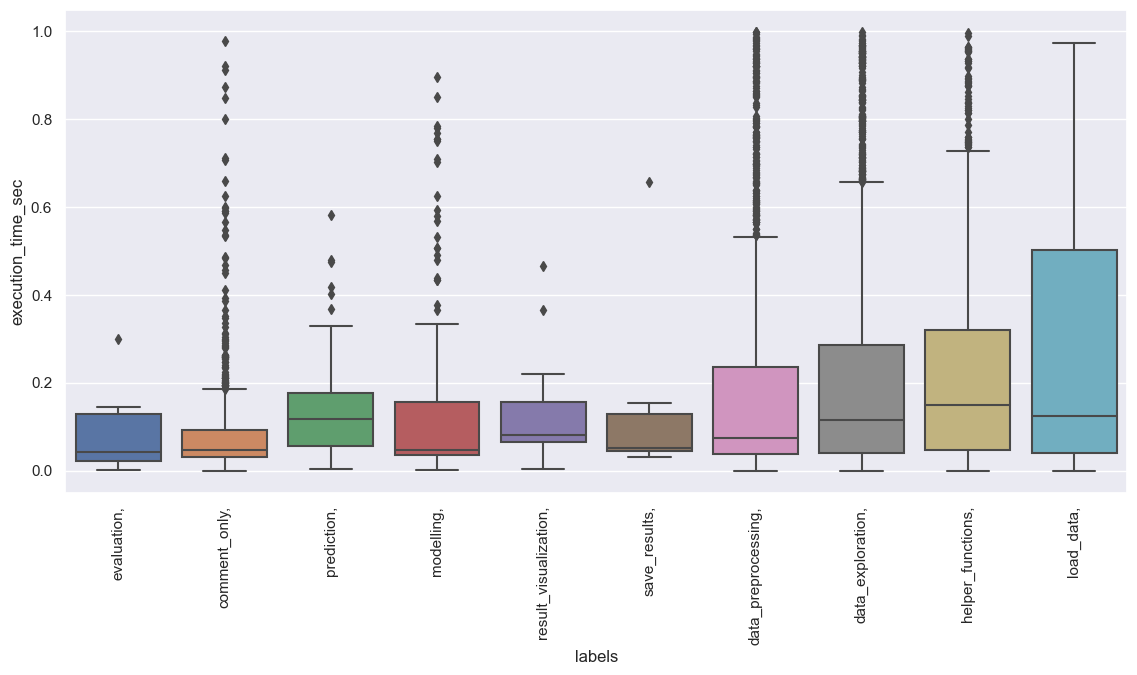

In [99]:
plot_box_time(metrics[metrics.execution_time_sec < 1], var='execution_time_sec')

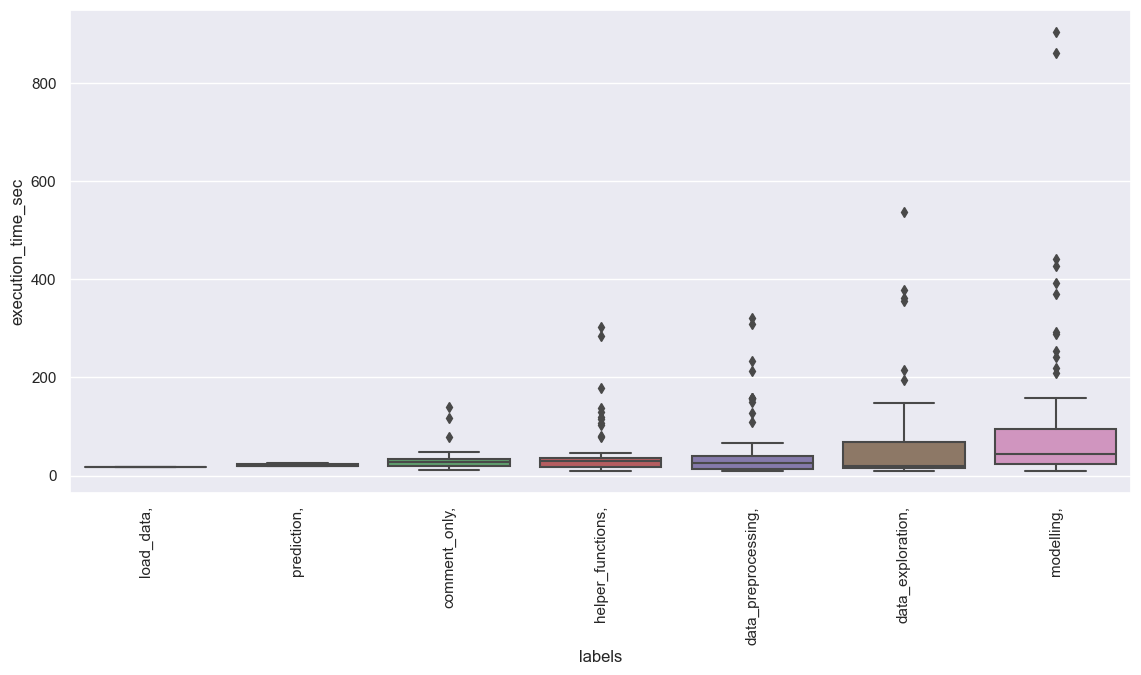

In [101]:
plot_box_time(metrics[metrics.execution_time_sec > 10], var='execution_time_sec')

In [125]:
metrics['scr_len'] = metrics.cell_source.str.len()

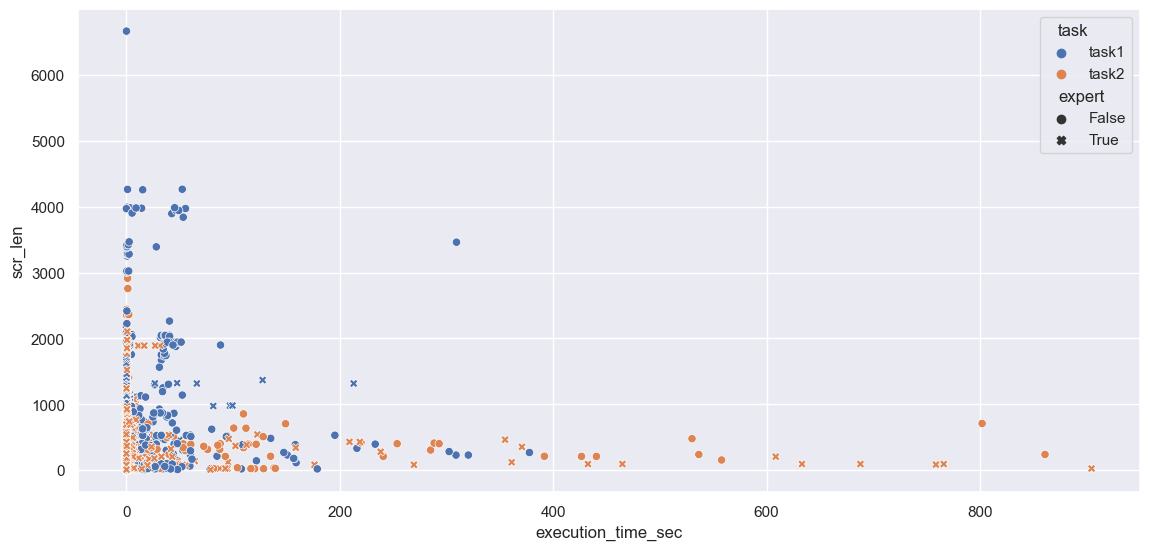

In [134]:
sns.scatterplot(metrics[metrics.event == 'execute'], x='execution_time_sec', y='scr_len', hue='task', style='expert');

In [129]:
pg.corr(metrics[metrics.event == 'execute'].execution_time_sec, metrics[metrics.event == 'execute'].scr_len)

,n,r,CI95%,p-val,BF10,power
pearson,8978,0.058308,"[0.04, 0.08]",3.224671e-08,5.728e+04,0.999822


In [94]:
# plot_box_time(metrics[metrics.execution_time_sec < 10], var='execution_time_sec')

# Interruptions

In [ ]:
metrics

In [111]:
test = metrics[metrics.labels.apply(lambda x: len(x.strip().split(',')) - 1 if isinstance(x, str) else None) == 1]

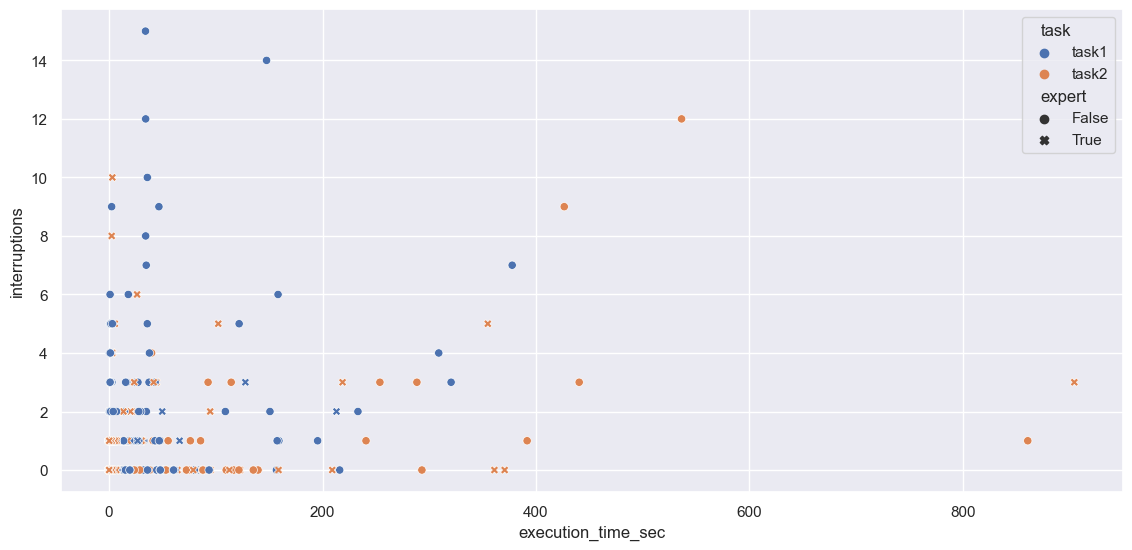

In [141]:
sns.scatterplot(test[test.labels != 'helper_functions,'], x='execution_time_sec', y='interruptions', hue='task', style='expert');

<Axes: xlabel='labels', ylabel='interruptions'>

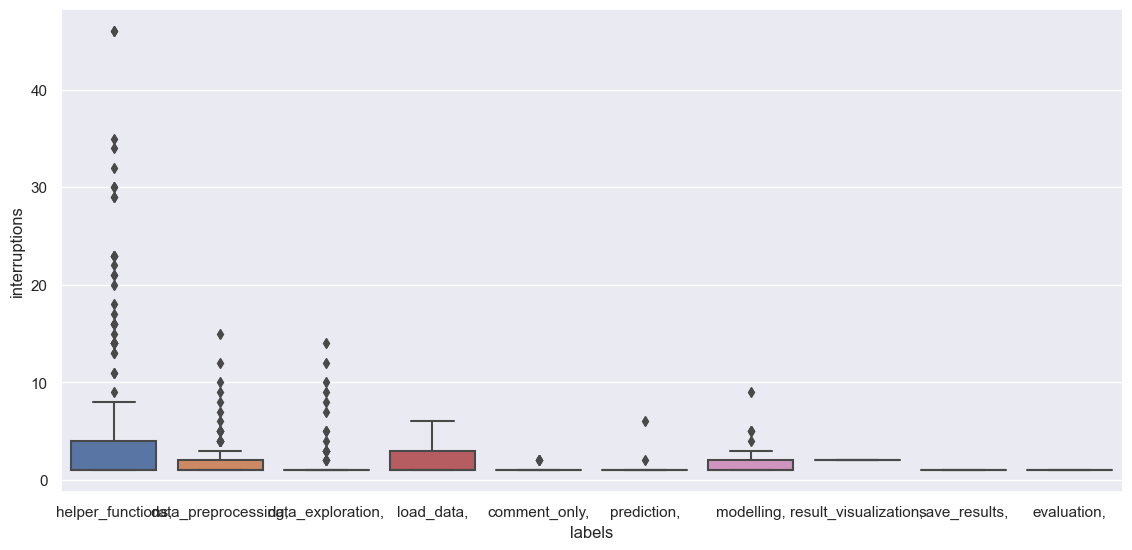

In [140]:
test_plot = test[(test.interruptions > 0)]
sns.boxplot(test_plot, x='labels', y='interruptions')